# Language Translation - "English to Bengali" using seq2seq models

In [ ]:
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Input, Dense

import matplotlib.pyplot as plt

Configuration parameters

In [2]:
LATENT_DIM = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

Load the language data

In [3]:
input_texts = []
target_texts = []
target_texts_inputs = []

t = 0
for line in open('ben.txt', encoding='utf-8'):
    
    t += 1
    if t > NUM_SAMPLES: 
        break
        
    if '\t' not in line: 
        continue
    
    input_text, translation = line.split('\t')[:2]
    
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
        
print("Number of samples loaded : ", len(input_texts))

print(input_texts[:8])
print(target_texts[:8])
print(target_texts_inputs[:8])

Number of samples loaded :  4342
['Go.', 'Go.', 'Go.', 'Run!', 'Run!', 'Who?', 'Fire!', 'Help!']
['যাও। <eos>', 'যান। <eos>', 'যা। <eos>', 'পালাও! <eos>', 'পালান! <eos>', 'কে? <eos>', 'আগুন! <eos>', 'বাঁচাও! <eos>']
['<sos> যাও।', '<sos> যান।', '<sos> যা।', '<sos> পালাও!', '<sos> পালান!', '<sos> কে?', '<sos> আগুন!', '<sos> বাঁচাও!']


#### Process the text corpus

Process the input corpus

In [4]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)

tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# Create the word-index mapping
word2idx_inputs = tokenizer_inputs.word_index
print("Total unique words in the input : ", len(word2idx_inputs))

# Get the length of the longest sequence
max_len_input = max([len(s) for s in input_sequences])
print("Max input sequence length : ", max_len_input)

Total unique words in the input :  1874
Max input sequence length :  19


Process the target corpuses

In [5]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')

tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# Create the word-outdex mapping for the output language
word2idx_outputs = tokenizer_outputs.word_index
num_words_output = len(word2idx_outputs) + 1
print("Total unique words in the output : ", num_words_output)

# Get the length of the longest sequence
max_len_target = max([len(s) for s in target_sequences])
print("Max output sequence length : ", max_len_target)

print("\n\nSome of the word-index output mappings : \n", dict(list(word2idx_outputs.items())[:10]))
print("\nTarget sequences :\n",target_sequences[:5])
print("\nTarget sequences inputs :\n",target_sequences_inputs[:5])

Total unique words in the output :  3543
Max output sequence length :  19


Some of the word-index output mappings : 
 {'<eos>': 1, '<sos>': 2, 'আমি': 3, 'টম': 4, 'আমার': 5, 'কি': 6, 'না।': 7, 'আপনি': 8, 'এটা': 9, 'তুমি': 10}

Target sequences :
 [[167, 1], [120, 1], [823, 1], [1717, 1], [1718, 1]]

Target sequences inputs :
 [[2, 167], [2, 120], [2, 823], [2, 1717], [2, 1718]]


#### Pad the inputs for the encoder

In [6]:
# Inputs for the encoder
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder input shape", encoder_inputs.shape)
print("encoder data sample", encoder_inputs[0])

# Inputs for the decoder
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("\ndecoder_input shape", decoder_inputs.shape)
print("decoder input data sample", decoder_inputs[0])

# Outputs from the decoder
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("\ndecoder_output shape", decoder_targets.shape)
print("decoder output data sample", decoder_targets[0])


encoder input shape (4342, 19)
encoder data sample [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 28]

decoder_input shape (4342, 19)
decoder input data sample [  2 167   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]

decoder_output shape (4342, 19)
decoder output data sample [167   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


#### Load the GloVe vectors

In [7]:
with open(r'E:\Machine Learning\Data\glove.6B\glove.6B.100d.txt', encoding='utf-8') as f:
    
    word2vec = {}
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.array(values[1:], dtype='float32')

f.close()

print(f"Loaded {len(word2vec)} word vectors")

Loaded 400000 word vectors


#### Create the embedding matrix

In [8]:
print("MAX_NUM_WORDS : ",MAX_NUM_WORDS)
print("Length of word2idx_input : ", len(word2idx_inputs))

num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print("Shape of embedding matrix : ", embedding_matrix.shape)

for word, i in word2idx_inputs.items():
    
    if i < MAX_NUM_WORDS:
        vector = word2vec.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

MAX_NUM_WORDS :  20000
Length of word2idx_input :  1874
Shape of embedding matrix :  (1875, 100)


Check if the embedding matrix contains any NaNs. If so the neural network weights would not change and the learning would stop

In [9]:
print("Does the embedding matrix contain any NaNs :", np.isnan(embedding_matrix).any())

Does the embedding matrix contain any NaNs : False


## The seq2seq model

#### Create the embedding layer

In [10]:
embedding_layer = Embedding(input_dim = num_words,
                            output_dim = EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length=max_len_input
                           )

#### Create the one-hot encoded targets for the decoder

We cannot use sparse_categorical_entropy for sequences, only categorical entropy

In [11]:
decoder_targets_one_hot = np.zeros(shape=(len(input_texts), max_len_target, num_words_output), dtype='float32')

print("Decoder targets one-hot encoding shape :",decoder_targets_one_hot.shape)

for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1  

Decoder targets one-hot encoding shape : (4342, 19, 3543)


#### Build the model

Set up the encoder:

Inputs --> Embedding layer --> LSTM layer

In [12]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)

encoder = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, h, c = encoder(x)

# Keep only the states to pass to the decoder
encoder_states = [h, c]

Set up the decoder

Decoder Inputs --> Embedding layer --> LSTM layer

In [21]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))

decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# Since the decoder is a "to-many" model so we have to return set return_sequences=True
decoder_lstm = LSTM(LATENT_DIM, 
                    return_sequences = True, 
                    return_state=True)

decoder_outputs, _ , _ = decoder_lstm(decoder_inputs_x, 
                                      initial_state=encoder_states)

Final Dense layer for predictions

In [22]:
decoder_dense = Dense(num_words_output, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Create the model

In [23]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 19, 100)      187500      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 19, 100)      354300      input_3[0][0]                    
____________________________________________________________________________________________

#### Train the model

In [24]:
BATCH_SIZE = 64
EPOCHS = 200
VALIDATION_SPLIT = 0.2

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=1)

r = model.fit([encoder_inputs, decoder_inputs], decoder_targets_one_hot,
               batch_size=BATCH_SIZE,
               epochs=EPOCHS,
               callbacks=[early_stopping, reduce_lr],
               validation_split=VALIDATION_SPLIT)

Train on 3473 samples, validate on 869 samples
Epoch 1/200
3473/3473 [==============================] - 5s 1ms/sample - loss: 2.7167 - accuracy: 0.7479 - val_loss: 3.1601 - val_accuracy: 0.6015
Epoch 2/200
3473/3473 [==============================] - 2s 605us/sample - loss: 1.4145 - accuracy: 0.7824 - val_loss: 2.8742 - val_accuracy: 0.6176
Epoch 3/200
3473/3473 [==============================] - 2s 600us/sample - loss: 1.2962 - accuracy: 0.8062 - val_loss: 2.8942 - val_accuracy: 0.6303
Epoch 4/200
3473/3473 [==============================] - 2s 601us/sample - loss: 1.2117 - accuracy: 0.8154 - val_loss: 2.8156 - val_accuracy: 0.6462
Epoch 5/200
3473/3473 [==============================] - 2s 603us/sample - loss: 1.1440 - accuracy: 0.8199 - val_loss: 2.8087 - val_accuracy: 0.6502
Epoch 6/200
3473/3473 [==============================] - 2s 603us/sample - loss: 1.0799 - accuracy: 0.8258 - val_loss: 2.7558 - val_accuracy: 0.6586
Epoch 7/200
3473/3473 [==============================] - 2s 6

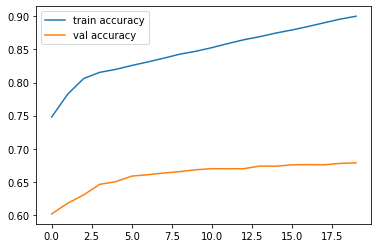

In [26]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

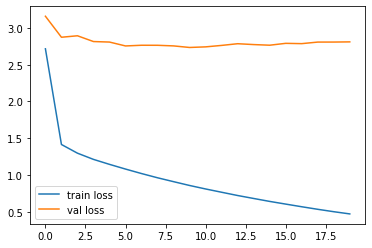

In [27]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

### Create the next encoder model

This model will take the RNN states and previous word as input, and accept a T=1 sequence

From this model we'll get the decoder initial hidden-states

In [28]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [29]:
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs  = [decoder_state_input_h, decoder_state_input_c]

In [30]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, 
                                     initial_state=decoder_states_inputs)
decoder_states = [h,c]

In [31]:
decoder_outputs = decoder_dense(decoder_outputs)

In [32]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

Map indexes back into words

In [33]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [34]:
def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_len_target):
        output_token, h, c = decoder_model.predict([target_seq] + states_value)
    
        idx = np.argmax(output_token[0, 0, :])
        
        if eos == idx:
            break
        
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)
            
        target_seq[0,0] = idx
        states_value = [h,c]
        
    return ' '.join(output_sentence)

### Test the outputs

In [55]:
i = np.random.choice(len(input_texts))
input_seq = encoder_inputs[i:i+1]
translation = decode_sequence(input_seq)

print(input_texts[i])
print(translation)

She's my wife.
ও আমার স্ত্রী।
